In [1]:
from google.colab import drive
drive.mount('/content/drive')
# uses modified version of scanpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install leidenalg

import os, sys
%cd "/content/drive/MyDrive/Colab Notebooks/scanpy"
sys.path.append(os.getcwd())
import os
import time
SCRIPT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/')
!pip install -e "/content/drive/MyDrive/Colab Notebooks/scanpy"
import scanpy as sc
import anndata as ann
import pandas as pd
import scipy.io
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from matplotlib import figure
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# INPUT_DATA = os.path.join(SCRIPT_DIR, "DATA","sc2")
DF_PROCESSEDv4_DATAPATH = os.path.join(SCRIPT_DIR, "DATA","DF","df_processedv4.h5ad")
FIGURE_DIR = os.path.join(SCRIPT_DIR, "Plots", "Initial_Clustering")

!pip freeze "/content/drive/MyDrive/Colab Notebooks/DATA/requirements.txt"

Mounted at /content/drive
     |████████████████████████████████| 1.4MB 7.5MB/s 
     |████████████████████████████████| 3.2MB 28.6MB/s 
/content/drive/MyDrive/Colab Notebooks/scanpy
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/scanpy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/b8/ac/92f7a3687270dabd13c4bf8ec9ec4e9577df75311743982d63a644cff780/anndata-0.7.6-py3-none-any.whl
Processing /root/.cache/pip/wheels/43/a4/e5/d4e0a170ccc134e509ea55acad7845f0fdfa62b964e430f0e3/sinfo-0.3.4-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a4/68/da997bc56bb69dcdcee4054f0bc42266909307b905389fbc54c9158f42da/legacy_api_wrap-1.2-py3-none-any.whl
Processing /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4/umap_learn-0.5.1-cp37-none-any.whl
  Using cached h

In [2]:
# Trains binary classifier on provided cluster
def train_classifier(t2, scm, clust_idx, use_xgboost=True, method='exact', n_estimators=1300, max_depth=7):
  f2 = scm.obs['Timepoint'] == t2
  X2 = scm[f2].X
  y2 = (scm[f2]).obs[clust_idx]
  if use_xgboost:
    param_dist = {'method':'exact', 'n_estimators':n_estimators, 
                  'max_depth': max_depth, 'binary':'logistic'}
  else: #TODO: random forest classifier
    print("Random forest not implemented yet")
    return
  clf = XGBClassifier(**param_dist)
  start = time.time()
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.9, test_size=0.1, random_state=2)
  # if len(y2_train.unique()) != len(y2_test.unique()):
    # raise ValueError("Train and test labels do not overlap")
  clf.fit(X2_train, y2_train)
  plot_confusion_matrix(clf,X2_test,y2_test)
  end = time.time()
  print("Model split and trained using {} in {} seconds".format(method, end-start))
  return X2_train, X2_test, y2_train, y2_test, clf

def timepoint_probabilities(scm, tp, clust, plots, n_neighbors,min_dist, resolution):
  scm_n = scm[scm.obs['Timepoint'] == tp]
  start = time.time()
  sc.pp.neighbors(scm_n, n_neighbors,random_state=1)
  sc.tl.umap(scm_n, min_dist, n_components=2, random_state=1, alpha=1)
  plots.append(scm_n)
  stage = scm_n.obs['Stage'][0]
  sc.pl.scatter(scm_n, 
                title='Timepoint: {} ({}), cells: {}, NN= {}'.format(tp, stage ,scm_n.n_obs, n_neighbors),
                basis='umap', color=clust, 
                save='_XGBOOST_CLUSTPROB_{}_TIMEPOINT_{}.png'.format(clust,tp))
  sc.pl.scatter(scm_n, 
                title='Timepoint: {} ({}), cells: {}, NN= {}'.format(tp, stage ,scm_n.n_obs, n_neighbors),
                basis='umap', color='leiden', save='_clust_OUTPUTS_Timepoint_{}.png'.format(tp))
  end = time.time()
  print("Time to visualize: "+ str(end-start) + " seconds")

In [3]:
# Graph Boost method
def nn_cluster_assignment(scm, tp, clust_idx, max_iter = 2, n_neighbors=15, neighbors_cutoff = 0.3, iteration_cutoff=0.005):
  scm_t = scm[scm.obs['Timepoint'] == tp]
  sc.pp.neighbors(scm_t, n_neighbors=n_neighbors+1)
  srm = scm_t.obsp['distances']
  print("Number of edges connected to cell 0: {}", len(np.argwhere(srm[0,:])))
  continue_assigning = True
  start = time.time()
  iter = 0
  while continue_assigning and iter <max_iter:
    n_unassigned_1 = scm_t[scm_t.obs[clust_idx] == 0].n_obs
    print("Number of cells not assigned to cluster {}: {}".format(clust_idx, n_unassigned_1))
    for cell_idx in range(srm.shape[0]):
      # skip checking on a cell_idx's neighbors if it is already assigned a cluster
      if scm_t.obs.at[scm_t.obs.index[cell_idx], clust_idx] == 1:
        continue
      nearest_obs = np.argwhere(srm[cell_idx,:])[:,1]
      vfunc = np.vectorize(lambda x: 1 if scm_t.obs.at[scm_t.obs.index[x], clust_idx] == 1 else 0)
      count_neighbors = np.sum(vfunc(nearest_obs))
      if count_neighbors/n_neighbors >= neighbors_cutoff:
        scm_t.obs.loc[scm_t.obs.index[cell_idx], clust_idx] = 1
    n_unassigned_2 = scm_t[scm_t.obs[clust_idx] == 0].n_obs
    # stop when new cells are being assigned to clusters at a very small proportion
    if n_unassigned_2 > (1-iteration_cutoff)*n_unassigned_1:
      continue_assigning = False
    iter += 1
  print("Number of cells not assigned to cluster {}: {}".format(clust_idx, n_unassigned_2))
  end = time.time()
  print("Time elapsed to conduct graph boost on {} at timepoint: {}: {}".format(clust_idx, tp, end-start))
  return scm_t

In [4]:
scm_ml = ann.read(DF_PROCESSEDv4_DATAPATH)
scm_ml.obs['leiden'] = scm_ml.obs['leiden'].astype(int)

#  add columns for probability and cluster assignments (all zeroes for now)
t_final = scm_ml.obs['Timepoint'].max()
num_classes = len(scm_ml[scm_ml.obs['Timepoint'] == t_final].obs['leiden'].unique())
# Column 'p(ci)' represents probability that an observation belongs to cluster i at t_final
prob_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                       index=scm_ml.obs.index, 
                       columns=['p(c'+str(i)+')' for i in range(num_classes)])
# Column ci represents formal cell assignment, based off a later-specified p threshold of p(ci)
clust_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                                    index=scm_ml.obs.index, 
                                    columns=['c' + str(i) for i in range(num_classes)])
scm_ml.obs = pd.concat([scm_ml.obs,prob_df,clust_df],axis=1)

# Assign initial ci with 1's to signify a cell belongs to the last timepoint leiden clusters; rest will remain zero 
for clust_idx in clust_df:
  clust_num = int(clust_idx[1:])
  f = (scm_ml.obs['leiden'] == clust_num) & (scm_ml.obs['Timepoint'] == t_final)
  scm_ml.obs.loc[f, clust_idx] = 1


In [5]:
def determine_trajectories(scm_ml, timepoints, clust_ids, p=0.5, max_iter=2, n_neighbors=15, neighbors_cutoff = 0.3, iteration_cutoff=0.005):
  n_timepoints = len(timepoints)
  for clust_id in clust_ids:
    for i in range(n_timepoints-1):      
      t2 = timepoints[-1*(i+1)]
      t1 = timepoints[-1*(i+2)]
      clust_idx = 'c' + str(clust_id)
      prob_idx = 'p(' + clust_idx + ')'
      X2_train, X2_test, y2_train, y2_test, clf = train_classifier(t2=t2, scm=scm_ml, clust_idx=clust_idx)
      labels = y2_test.unique()
      labels.sort()
      if t2 == t_final:
        # Just for completion, assign probabilities for initial timepoint as well
        X_t2= scm_ml[scm_ml.obs['Timepoint'] == t2].X
        y_t2 = clf.predict_proba(X_t2)
        scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t2,prob_idx] = y_t2[:,1]
        # plot
        # timepoint_probabilities(scm_ml, t2, clust_idx, plots, n_neighbors=15, min_dist=0.3, resolution=1)
        # don't need to change cluster assignments since we already did that for t_final
      X_t1= scm_ml[scm_ml.obs['Timepoint'] == t1].X
      y_t1 = clf.predict_proba(X_t1)
      # update new probabilities at t1
      scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1,prob_idx] = y_t1[:,1]
      # update specified cluster's assignments for t1
      scm_ml.obs.loc[(scm_ml.obs['Timepoint'] == t1) & (scm_ml.obs[prob_idx] > p), clust_idx] = 1
      # conduct graph boosting for this specific cluster at t1
      scm_t = nn_cluster_assignment(scm_ml, t1, clust_idx, max_iter = max_iter, n_neighbors=n_neighbors, neighbors_cutoff = neighbors_cutoff, iteration_cutoff=iteration_cutoff)
      scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1, clust_idx] = scm_t.obs[clust_idx]
      # timepoint_probabilities(scm_ml, t1, clust_idx, plots, n_neighbors=15, min_dist=0.3, resolution=1)
  return scm_ml

In [6]:
plots = []
clust_ids = [6]
neighbors_cutoff = 0.3
iteration_cutoff = 0.005
max_iter=2
n_neighbors = 15
p=0.5

In [11]:
timepoints = sorted(scm_ml.obs['Timepoint'].unique())
# scm_ml = determine_trajectories(scm_ml, timepoints, clust_ids, p=p, max_iter=max_iter, n_neighbors=n_neighbors, neighbors_cutoff = neighbors_cutoff, iteration_cutoff=iteration_cutoff)
print(timepoints)

[3.3, 3.8, 4.3, 4.7, 5.3, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


In [ ]:
def compare_clustering(scm_ml, timepoints, clust_idx, prob=None, n_rows=8, n_cols=3):
  print(clust_idx)
  n_timepoints = len(timepoints)
  if n_rows * n_cols != 2*n_timepoints:
    raise ValueError("Number of rows and number of columns must multiply to total number of plots")
  # Don't want the scanpy plot to interpret the values as continuous variables
  scm_ml.obs['leiden'] = scm_ml.obs['leiden'].astype(str)
  if prob is None:
    scm_ml.obs[clust_idx] = scm_ml.obs[clust_idx].astype(str)
  fig, ax_arr = plt.subplots(n_rows, n_cols, figsize=(n_cols*10,n_rows*9))
  plot_ml_cluster = True
  # create tuple array that helps plot the leiden plots and ml clustering results to alternate rows (1st row leiden, second row ml...3rd row leiden, etc.)
  new_indices = []
  original_indices = list(range(n_timepoints))
  slice_width = n_cols
  num_repeats = 2 # 1 for ledien cluster plot, 1 for ml plot
  for j in range(int(n_rows/2)):
    for k in range(num_repeats):
      new_indices = new_indices + original_indices[j*slice_width: (j+1)*slice_width]
  t_axes_tuple = tuple(zip(new_indices,ax_arr.flatten()))
  for i, ax in t_axes_tuple:
    if i % n_cols == 0:
      plot_ml_cluster = not plot_ml_cluster
    t= timepoints[-1 * (i+1)]
    scm_t = scm_ml[scm_ml.obs['Timepoint'] == t]
    sc.pp.neighbors(scm_t, n_neighbors=15,random_state=1)
    sc.tl.umap(scm_t, min_dist=0.3, n_components=2, random_state=1, alpha=1)
    if plot_ml_cluster and prob is None:
      sc.pl.scatter(scm_t, 
                  title='iGraphBoost, Timepoint: {}, Cluster: {} n_cells: {}'.format(t, clust_idx, scm_t.n_obs), 
                  basis='umap', color=clust_idx, ax=ax, show = False)
    elif plot_ml_cluster and prob is not None: # scanpy bug with subplots and probability scales
      sns.scatterplot(x=scm_t.obsm['X_umap'][:,0], y=scm_t.obsm['X_umap'][:,1], hue=scm_t.obs[clust_idx], ax=ax)
    else:
      sc.pl.scatter(scm_t, 
                    title='Leiden clustering, Timepoint: {}, n_cells: {}'.format(t, scm_t.n_obs), 
                    basis='umap', color='leiden', ax=ax, show = False)

In [ ]:
# for id in clust_ids:
#   clust_idx = 'c' + str(id)
#   prob_idx = 'p(c' + str(id) + ')'
#   compare_clustering(scm_ml, timepoints, clust_idx = prob_idx, prob=True)
#   plt.tight_layout(pad=3.0)
#   plt.savefig('{}, num_Neighbors_cutoff = {}, classification_cutoff = {}.png'.format(prob_idx, neighbors_cutoff,p))
#   plt.show()
# sns.heatmap(data=scm_t.obsm['X_pca'], hue=scm_t.obs[clust_idx])

25
(25, 20)
c0
c1
c2
c3
c4
c5
c6
c7
c8
c9
c10
c11
c12
c13
c14
c15
c16
c17
c18
c19
c20
c21
c22
c23
c24


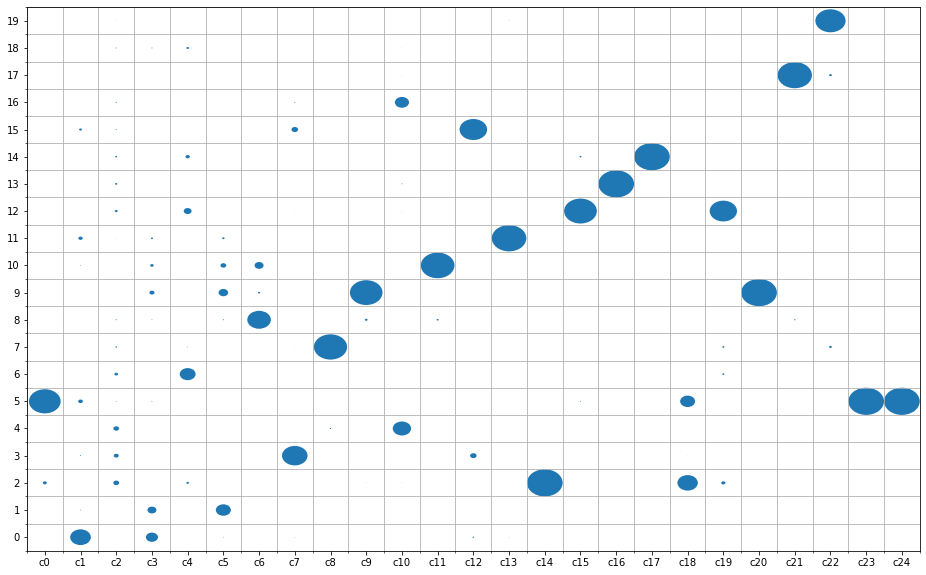

In [127]:
CLUSTERING_PATH = os.path.join(SCRIPT_DIR,"DATA","DF","df_nc{}_p{}.h5ad".format(neighbors_cutoff,p))
adata = ann.read(CLUSTERING_PATH)
from matplotlib.collections import PatchCollection
def confusion_matrix(adata, timepoints,y_idx):
  # y_idx = new cluster assignment (leiden)
  # x_idx = old cluster assignment (c)
  t_final = timepoints[-1]
  for i in range(1):
    t = timepoints[-1*(i+2)]
    tfilt = adata.obs['Timepoint'] == t
    ylabels = sorted(adata.obs[tfilt][y_idx].unique())
    xlabels = ["c" + str(i) for i in range(0, len(adata.obs[adata.obs['Timepoint'] == t_final]['leiden'].unique()))]
    M = len(xlabels)
    N = len(ylabels)
    print(len(xlabels))
    x, y = np.meshgrid(np.arange(M), np.arange(N), indexing='ij')
    s = np.zeros_like(x,dtype='float')
    print(s.shape)
    for i in range(0, s.shape[0]):
      colfilt = adata.obs[xlabels[i]] == 1
      print(xlabels[i])
      tot_cells_classified = adata.obs[colfilt & tfilt].shape[0]
      for j in range(0, s.shape[1]):
        if tot_cells_classified == 0:
          s[i,j] = 0
        else:
          classified_in_clust = adata.obs[tfilt & colfilt & (adata.obs[y_idx] == j)].shape[0]
          s[i,j] = float(classified_in_clust)/tot_cells_classified   
    c = np.zeros(shape=(M, N))
    fig, ax = plt.subplots()
    fig.set_size_inches(16,10)
    R = s/s.max()/2
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    col = PatchCollection(circles)
    ax.add_collection(col)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
          xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.grid(which='minor')
    plt.show()
confusion_matrix(adata, timepoints, 'leiden')

In [33]:


a = np.random.randint(0,180,size=(5,6))
print(a)
print(a[0][2])

[[ 35  85 147 162  53  77]
 [ 81 135   9 134 106  49]
 [ 11 106  53 129 122  17]
 [ 94   2 126  18 162  20]
 [ 87  82  34 148  26   3]]
147
